# **Import Data**

In [15]:
!kaggle competitions download -c data-analytics-competition-find-it-2024

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [16]:
#import zipfile module
from zipfile import ZipFile

with ZipFile('data-analytics-competition-find-it-2024.zip', 'r') as f:
    #extract in current directory
    f.extractall()

FileNotFoundError: [Errno 2] No such file or directory: 'data-analytics-competition-find-it-2024.zip'

# **Libraries**

In [ ]:
import warnings

# Menetapkan aturan untuk mengabaikan semua warning
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from scipy import stats
from scipy.stats import spearmanr

# Modelling
import optuna
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb


# Model Evaluation
from sklearn.metrics import f1_score, classification_report

# **Data Loading**

In [ ]:
df_train = pd.read_csv("train_features.csv")

**Insight :** Terdapat 3817 baris dan 16 kolom/fitur pada data train

In [ ]:
df_train.info()

NameError: name 'df_train' is not defined

**Insight :** 
1. Dengan jumlah baris 3817 pada data train, semua memiliki missing value terkecuali fitur tahun_kelahiran
2. Fitur tanggal_menjadi_anggota seharusnya memiliki tipe data datetime

In [ ]:
df_train.describe()

,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan
count,3817.000000,3.627000e+03,3627.000000,3613.000000,3645.000000,3636.000000,3.639000e+03,3624.000000,3603.000000,3639.000000,3652.000000,3648.000000,3621.000000
mean,1967.823946,1.144832e+08,0.293080,0.353723,47.231550,59804.239824,4.385748e+05,81428.997792,63377.970580,2.125584,4.436473,5.767818,0.004971
std,11.768131,4.346042e+07,0.473063,0.493014,27.068512,74024.976109,5.120427e+05,99976.226855,79435.457282,2.100133,3.002522,3.210738,0.070340
min,1899.000000,5.073000e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,8.112512e+07,0.000000,0.000000,25.000000,7907.000000,4.947950e+04,10115.000000,7947.000000,0.000000,2.000000,3.000000,0.000000
50%,1968.000000,1.156214e+08,0.000000,0.000000,47.000000,26456.000000,2.219930e+05,36054.500000,27795.000000,2.000000,4.000000,5.000000,0.000000
75%,1976.000000,1.504960e+08,1.000000,1.000000,69.000000,86162.000000,6.863555e+05,121380.000000,89502.500000,3.000000,7.000000,8.000000,0.000000
max,2000.000000,3.328840e+08,2.000000,2.000000,128.000000,396508.000000,3.489675e+06,621600.000000,542164.000000,20.000000,30.000000,17.000000,1.000000


**Insight :** 
1. Beberapa fitur memiliki kemungkinan distribusi normal dikarenakan memiliki perbedaan nilai yang tidak terlalu jauh
2. Fitur fitur belanja yang mengenai harga kemungkinan tinggi memiliki outlier dan distribusinya skew
3. Perlu dilakukan scaling dikarenakan beberpa fitur memiliki perbedaan nilai yang tinggi

In [ ]:
df_train.duplicated().sum()

0

In [ ]:
y_train = pd.read_csv("train_labels.csv")
y_train

,jumlah_promosi
0,2
1,0
2,1
3,4
4,4
...,...
3812,5
3813,1
3814,0
3815,0


# **EDA**

1. Bagaimana missing value terjadi?
2. Bagaimana distribusi data masing masing fitur?
3. Apakah terdapat outlier?
4. Apakah datanya balance?

## 1. Bagaimana missing value terjadi?

In [ ]:
df_train

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17
2,1966,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN
3,1961,Magister,Rencana Menikah,165579620.0,0.0,0.0,90.0,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,NaN
4,1970,Sarjana,Rencana Menikah,117703159.0,1.0,1.0,78.0,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,1955,Magister,Menikah,78199470.0,0.0,0.0,33.0,6069.0,25977.0,3856.0,5784.0,5.0,1.0,0.0,0.0,NaN
3813,1947,Doktor,Rencana Menikah,109306000.0,0.0,1.0,44.0,0.0,50575.0,NaN,0.0,3.0,6.0,3.0,0.0,2014-06-09
3814,1974,Magister,Menikah,104621000.0,0.0,2.0,68.0,2023.0,62713.0,8092.0,0.0,7.0,5.0,7.0,0.0,2013-11-07
3815,1957,SMA,Rencana Menikah,110850000.0,1.0,1.0,67.0,18207.0,70805.0,24276.0,NaN,4.0,5.0,4.0,0.0,2013-06-30


Jika dilihat pada pendidikan maupun status_pernikahan mungkin terdapat suatu pola dengan contoh :
1. Sarjana 
2. Sarjana
3. Sarjana
4. SMA
5. SMA
maka untuk imputasi `pendidikan` dan `status_pernikahan` akan dilakukan fillna sesuai value setelahnya

untuk sisanya akan dilakukan imputasi menggunakan KNN Imputer karna berdasarkan pola yang didapat sebelumnya

## 2. Bagaimana distribusi data masing masing fitur?

### Numeric

In [ ]:
fitur_number = df_train.select_dtypes(include=['int', 'float']).columns # Mengambil fitur fitur yang bertipe data integer dan float
highly_skewed = []
moderately_skewed = []
normal_skewed = []

# Perulangan untuk mengecek skewnes masing masing fitur 
for i in df_train[fitur_number].columns : 
    nilai_skew = df_train[i].skew() # Hitung skewness
    if nilai_skew < -1 or nilai_skew > 1 : # Jika skewnessnya lebih besar dari 1 atau lebih kecil -1
        highly_skewed.append(i)
    elif (nilai_skew >= -1 and nilai_skew <= -0.5) or (nilai_skew <= 1 and nilai_skew >= 0.5) :  # Jika skewnessnya di antara -1 dan -0.5 atau di antara 1 dan 0.5
        moderately_skewed.append(i)
    else : # Jika skewnessnya tidak memenuhi dua kondisi di atas
        normal_skewed.append(i)

In [ ]:
for i in highly_skewed :
    print(i, end=", ")

NameError: name 'highly_skewed' is not defined

In [ ]:
for i in moderately_skewed :
    print(i, end=", ")

jumlah_anak_remaja, pembelian_web, 

In [ ]:
for i in normal_skewed :
    print(i, end=", ")

tahun_kelahiran, pendapatan, terakhir_belanja, pembelian_toko, 

**Insight :** Sesuai dengan yang sudah ditemukan pada data loading beberapa fitur memiliki distribusi normal dan distribusi skew

### Categorical

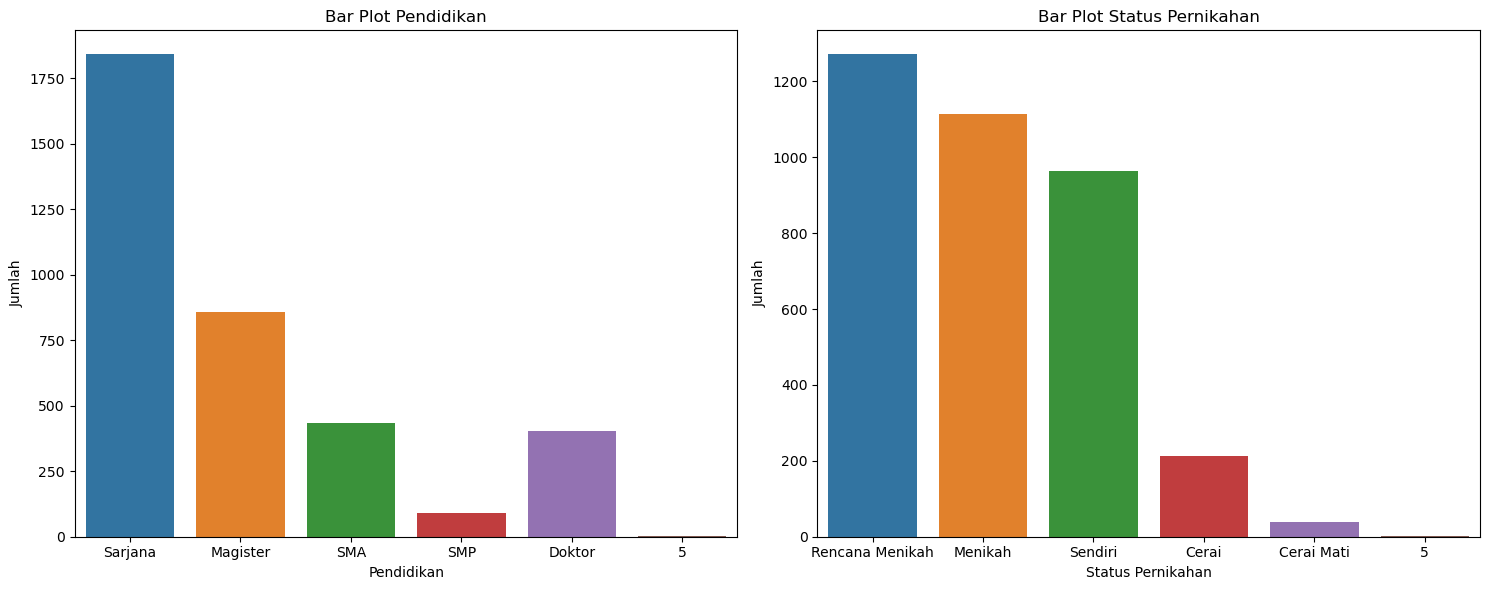

In [ ]:
# Membuat dua bar plot terpisah
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot untuk pendidikan
sns.countplot(data=df_train, x='pendidikan', ax=axes[0])
axes[0].set_title('Bar Plot Pendidikan')
axes[0].set_xlabel('Pendidikan')
axes[0].set_ylabel('Jumlah')

# Bar plot untuk status pernikahan
sns.countplot(data=df_train, x='status_pernikahan', ax=axes[1])
axes[1].set_title('Bar Plot Status Pernikahan')
axes[1].set_xlabel('Status Pernikahan')
axes[1].set_ylabel('Jumlah')

plt.tight_layout()
plt.show()

**Insight :** 
1. Tiap kategori memiliki perbedaan jumlah data yang cukup tinggi
2. Pada pendidikan maupun status_pernikahan terdapat kategori `5` yang tidak diketahui maksudnya, sehingga perlu dilakukan drop

## 3. Apakah terdapat outlier?

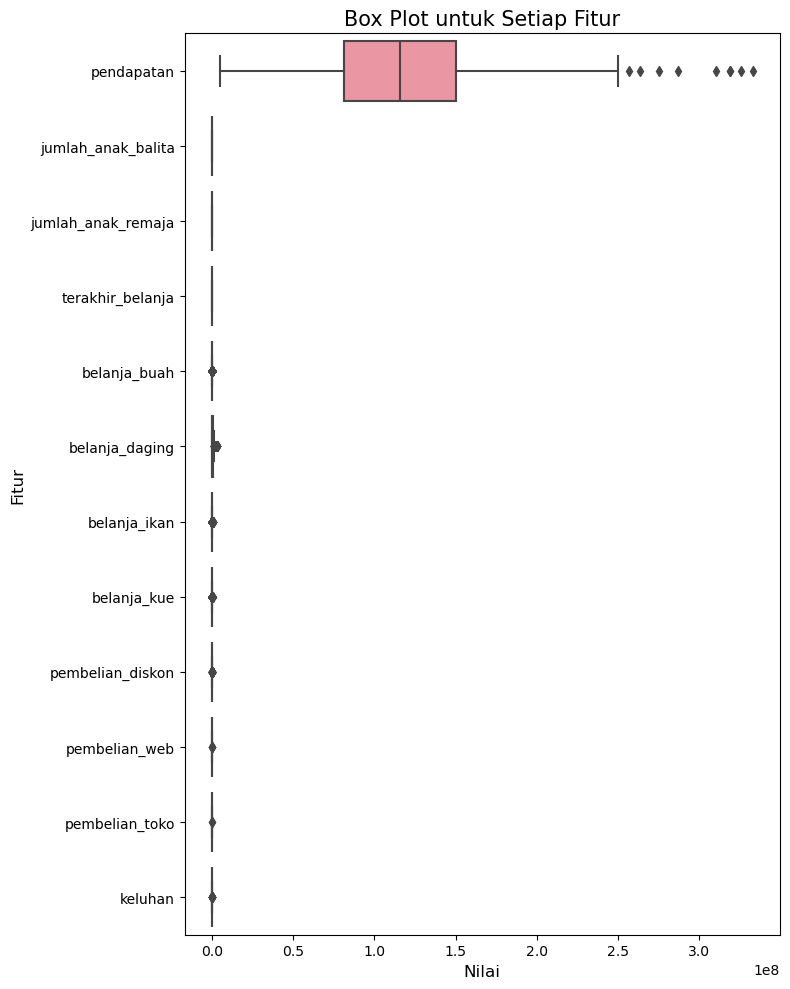

In [ ]:
kolom = df_train.columns

# Set up figure and axes
fig, axes = plt.subplots(figsize=(8, 10))

# Plot the box plot
sns.boxplot(data=df_train.drop(columns=kolom[0]), orient='h', ax=axes)

# Set title and labels
axes.set_title('Box Plot untuk Setiap Fitur', fontsize=15, loc='center')
axes.set_ylabel('Fitur', fontsize=12)
axes.set_xlabel('Nilai', fontsize=12)

plt.tight_layout()
plt.show()

**Insight :** 
1. Hanya fitur `jumlah_anak_balita`,`jumlah_anak_remaja`, dan `terakhir_belanja` yang tidak memiliki outlier
2. Outlier yang terjadi memiliki kemungkinan terjadi secara alami sehingga tidak perlu dilakukan trimming

## 4. Apakah datanya balance?

In [ ]:
y_train.value_counts()

jumlah_promosi
0                 983
5                 557
1                 515
4                 515
3                 472
2                 389
6                 386
Name: count, dtype: int64

**Insight :** Perbedaan nilainya tidak terlalu jauh, memungkinkan untuk dilakukan balancing data dengan metode SMOTE dan seimbangkan di nilai tengah

# **Feature Engineering**

## Split Data

In [ ]:
# Ubah kolom ke tipe datetime
df_train['tanggal_menjadi_anggota'] = pd.to_datetime(df_train['tanggal_menjadi_anggota'])

# Ambil hanya tahunnya
df_train['tanggal_menjadi_anggota'] = df_train['tanggal_menjadi_anggota'].dt.year

In [ ]:
X = df_train
y = y_train
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.05,random_state=200)

In [ ]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Missing Value Handling

In [ ]:
X_train.columns

Index(['tahun_kelahiran', 'pendidikan', 'status_pernikahan', 'pendapatan',
       'jumlah_anak_balita', 'jumlah_anak_remaja', 'terakhir_belanja',
       'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue',
       'pembelian_diskon', 'pembelian_web', 'pembelian_toko', 'keluhan',
       'tanggal_menjadi_anggota'],
      dtype='object')

In [ ]:
X_train['pendidikan'] = X_train['pendidikan'].replace("5", np.nan)
X_test['pendidikan'] = X_test['pendidikan'].replace("5", np.nan)

X_train['status_pernikahan'] = X_train['status_pernikahan'].replace("5", np.nan)
X_test['status_pernikahan'] = X_test['status_pernikahan'].replace("5", np.nan)


X_train['pendidikan'] = X_train['pendidikan'].fillna(method='bfill')
X_test['pendidikan'] = X_test['pendidikan'].fillna(method='bfill')

X_train['status_pernikahan'] = X_train['status_pernikahan'].fillna(method='bfill')
X_test['status_pernikahan'] = X_test['status_pernikahan'].fillna(method='bfill')

In [ ]:
X_test['status_pernikahan'] = X_test['status_pernikahan'].fillna("Menikah")

In [ ]:
koloms = list(X_train.columns)
koloms.remove("pendidikan")
koloms.remove("status_pernikahan")
koloms.remove("tanggal_menjadi_anggota")

# Inisialisasi KNNImputer dengan jumlah tetangga 2
imputer = KNNImputer(n_neighbors=2)

# Terapkan imputer pada data
imputed_data_train = imputer.fit_transform(X_train[koloms])
imputed_data_test = imputer.fit_transform(X_test[koloms])

# Bulatkan hasil imputasi ke bawah
imputed_data_floor_train = np.floor(imputed_data_train)
imputed_data_floor_test = np.floor(imputed_data_test)

# Ubah kembali hasil imputasi ke dalam DataFrame
X_train_imputed = pd.DataFrame(imputed_data_floor_train, columns=koloms)
X_test_imputed = pd.DataFrame(imputed_data_floor_test, columns=koloms)

In [ ]:
X_train_imputed['pendidikan'] = X_train['pendidikan']
X_train_imputed['status_pernikahan'] = X_train['status_pernikahan']
X_train_imputed['tanggal_menjadi_anggota'] = X_train['tanggal_menjadi_anggota']

X_test_imputed['pendidikan'] = X_test['pendidikan']
X_test_imputed['status_pernikahan'] = X_test['status_pernikahan']
X_test_imputed['tanggal_menjadi_anggota'] = X_test['tanggal_menjadi_anggota']

In [ ]:
koloms = list(X_train.columns)
koloms.remove("pendidikan")
koloms.remove("status_pernikahan")

# Inisialisasi KNNImputer dengan jumlah tetangga 2
imputer = KNNImputer(n_neighbors=6)

# Terapkan imputer pada data
imputed_data_train = imputer.fit_transform(X_train_imputed[["tanggal_menjadi_anggota"]].values)
imputed_data_test = imputer.fit_transform(X_test_imputed[["tanggal_menjadi_anggota"]].values)

# Bulatkan hasil imputasi ke bawah
imputed_data_floor_train = np.floor(imputed_data_train)
imputed_data_floor_test = np.floor(imputed_data_test)

# Ubah kembali hasil imputasi ke dalam DataFrame
X_train_imputed['tanggal_menjadi_anggota'] = imputed_data_floor_train
X_test_imputed['tanggal_menjadi_anggota'] = imputed_data_floor_test

In [ ]:
X_train.tail(10)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
3616,1968,Sarjana,Rencana Menikah,150458229.0,0.0,0.0,18.0,202966.0,1518978.0,216754.0,203023.0,2.0,8.0,5.0,0.0,NaN
3617,1959,SMA,Cerai,156864000.0,0.0,0.0,86.0,119357.0,228599.0,95081.0,254898.0,1.0,NaN,10.0,0.0,NaN
3618,1972,Doktor,Cerai,117001000.0,0.0,1.0,87.0,8092.0,131495.0,NaN,10115.0,3.0,9.0,9.0,0.0,2013.0
3619,1973,Doktor,Sendiri,121732000.0,0.0,1.0,73.0,NaN,38437.0,10115.0,NaN,1.0,7.0,NaN,0.0,2014.0
3620,1963,Magister,Menikah,114060350.0,0.0,NaN,52.0,6402.0,100941.0,1689.0,NaN,3.0,10.0,4.0,NaN,NaN
3621,1968,Sarjana,Sendiri,143622000.0,0.0,NaN,68.0,107219.0,530026.0,254898.0,119357.0,NaN,5.0,6.0,0.0,NaN
3622,1949,Magister,Menikah,160275902.0,0.0,0.0,51.0,171649.0,970380.0,231210.0,89350.0,1.0,2.0,6.0,0.0,NaN
3623,1978,Sarjana,Sendiri,97163000.0,0.0,1.0,46.0,2023.0,NaN,0.0,8092.0,1.0,2.0,2.0,0.0,2013.0
3624,1969,Magister,Sendiri,126368979.0,0.0,0.0,73.0,45678.0,863781.0,130640.0,NaN,0.0,2.0,NaN,0.0,NaN
3625,1951,Sarjana,Menikah,109295649.0,0.0,0.0,16.0,54306.0,234150.0,76072.0,15567.0,2.0,7.0,4.0,0.0,NaN


In [ ]:
X_train_imputed.tail(10)

,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,pendidikan,status_pernikahan,tanggal_menjadi_anggota
3616,1968.0,150458229.0,0.0,0.0,18.0,202966.0,1518978.0,216754.0,203023.0,2.0,8.0,5.0,0.0,Sarjana,Rencana Menikah,2013.0
3617,1959.0,156864000.0,0.0,0.0,86.0,119357.0,228599.0,95081.0,254898.0,1.0,7.0,10.0,0.0,SMA,Cerai,2013.0
3618,1972.0,117001000.0,0.0,1.0,87.0,8092.0,131495.0,16574.0,10115.0,3.0,9.0,9.0,0.0,Doktor,Cerai,2013.0
3619,1973.0,121732000.0,0.0,1.0,73.0,15384.0,38437.0,10115.0,8948.0,1.0,7.0,2.0,0.0,Doktor,Sendiri,2014.0
3620,1963.0,114060350.0,0.0,0.0,52.0,6402.0,100941.0,1689.0,6622.0,3.0,10.0,4.0,0.0,Magister,Menikah,2013.0
3621,1968.0,143622000.0,0.0,0.0,68.0,107219.0,530026.0,254898.0,119357.0,0.0,5.0,6.0,0.0,Sarjana,Sendiri,2013.0
3622,1949.0,160275902.0,0.0,0.0,51.0,171649.0,970380.0,231210.0,89350.0,1.0,2.0,6.0,0.0,Magister,Menikah,2013.0
3623,1978.0,97163000.0,0.0,1.0,46.0,2023.0,63724.0,0.0,8092.0,1.0,2.0,2.0,0.0,Sarjana,Sendiri,2013.0
3624,1969.0,126368979.0,0.0,0.0,73.0,45678.0,863781.0,130640.0,165706.0,0.0,2.0,7.0,0.0,Magister,Sendiri,2013.0
3625,1951.0,109295649.0,0.0,0.0,16.0,54306.0,234150.0,76072.0,15567.0,2.0,7.0,4.0,0.0,Sarjana,Menikah,2013.0


## Outlier Handling

In [ ]:
# skewed_column = highly_skewed+moderately_skewed
# skewed_column.remove("keluhan") # memiliki variasa rendah



# # Metode Capping untuk Distribusi Skew
# winsorizer_skewed = Winsorizer(capping_method='iqr',
#                             tail='both',
#                             fold=3,
#                             variables=skewed_column,
#                             missing_values='ignore')

# # Fit & Transforming X_train 
# X_train_capped = winsorizer_skewed.fit_transform(X_train_imputed)
# X_test_capped = winsorizer_skewed.transform(X_test_imputed)

In [ ]:
# # Plot Distribution Comparison
# def outlier_handling_plot_comparison(df_before, df_after, variable):
#     """
#     This function is created to plot histograms and boxplots for a variable before and after outlier handling
    
#     Parameters:
#     - df_before (pandas.DataFrame): DataFrame before outlier handling
#     - df_after (pandas.DataFrame): DataFrame after outlier handling
#     - variable (str): The variable to plot
    
#     Example: 
#     num_cols = ['numeric_column']                                   <- Enter the numeric column
#     for col in num_cols:                                            <- make a for loop in numeric column to access every columns
#         plot_distribution_comparison(X_train, X_train_capped, col)  <- put X_train, X_train_capped, and columns in the variable

#     """
#     # Figure Size, and Super Title based on variable
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))                               
#     fig.suptitle(f'{variable} - Distribution Before and After Outlier Handling')

#     # Plot Histogram Before
#     sns.histplot(df_before[variable], bins=30, ax=axes[0, 0], color='skyblue')
#     axes[0, 0].set_title('Histogram Before')

#     # Plot Boxplot Before
#     sns.boxplot(y=df_before[variable], ax=axes[1, 0], color='lightgreen')
#     axes[1, 0].set_title('Boxplot Before')

#     # Plot Histogram After
#     sns.histplot(df_after[variable], bins=30, ax=axes[0, 1], color='skyblue')
#     axes[0, 1].set_title('Histogram After')

#     # Plot Boxplot After
#     sns.boxplot(y=df_after[variable], ax=axes[1, 1], color='lightgreen')
#     axes[1, 1].set_title('Boxplot After')

#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()


In [ ]:
# for col in skewed_column:
#     outlier_handling_plot_comparison(X_train, X_train_capped, col)

Beberapa masih memiliki outlier sehingga untuk scaling dan feature selection perlu disesuaikan

## Feature Selection

In [ ]:
selected_column = list(df_train.columns)
selected_column.remove("tanggal_menjadi_anggota")

In [ ]:
X_train_selected = X_train_imputed[selected_column]
X_test_selected = X_test_imputed[selected_column]

## Encoding

### Nominal

In [ ]:
list_nom = ['status_pernikahan']

enc_ohe = OneHotEncoder(sparse_output=False) # sparse_output=False agar tidak sparse metric
enc_ohe.fit(X_train_selected[list_nom])
X_train_ohe = enc_ohe.transform(X_train_selected[list_nom])
X_test_ohe = enc_ohe.transform(X_test_selected[list_nom])

In [ ]:
feature_names = enc_ohe.get_feature_names_out(input_features=list_nom)
feature_names

array(['status_pernikahan_Cerai', 'status_pernikahan_Cerai Mati',
       'status_pernikahan_Menikah', 'status_pernikahan_Rencana Menikah',
       'status_pernikahan_Sendiri'], dtype=object)

In [ ]:
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=feature_names)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=feature_names)
X_train_ohe_df.head()

,status_pernikahan_Cerai,status_pernikahan_Cerai Mati,status_pernikahan_Menikah,status_pernikahan_Rencana Menikah,status_pernikahan_Sendiri
0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0


In [ ]:
X_train_selected.reset_index(drop=True, inplace=True)
X_test_selected.reset_index(drop=True, inplace=True)

In [ ]:
X_train_final = pd.concat([X_train_selected, X_train_ohe_df], axis=1)
X_test_final = pd.concat([X_test_selected, X_test_ohe_df], axis=1)

In [ ]:
X_train_final.drop('status_pernikahan', axis=1, inplace=True)
X_test_final.drop('status_pernikahan', axis=1, inplace=True)

### Ordinal

In [ ]:
pemetaan = {'SMP': 0, 'SMA': 1, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5} 

X_train_final['pendidikan'] = X_train_final['pendidikan'].map(pemetaan)
X_test_final['pendidikan'] = X_test_final['pendidikan'].map(pemetaan)

## Scaling

In [ ]:
koloms = list(X_train_final.columns)

scaler = RobustScaler()
X_train_scale = scaler.fit_transform(X_train_final[koloms])
X_test_scale = scaler.transform(X_test_final[koloms])

In [ ]:
# Konversi array menjadi DataFrame dengan kolom yang sesuai
X_train_scale_df = pd.DataFrame(X_train_scale, columns=koloms)
X_test_scale_df = pd.DataFrame(X_test_scale, columns=koloms)

In [ ]:
X_train_scale_df

,tahun_kelahiran,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,status_pernikahan_Cerai,status_pernikahan_Cerai Mati,status_pernikahan_Menikah,status_pernikahan_Rencana Menikah,status_pernikahan_Sendiri
0,-1.294118,-3.0,-1.211782,1.0,1.0,-0.441860,0.088744,-0.344297,0.071319,-0.167836,1.333333,-0.8,-0.8,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.941176,1.0,0.292731,0.0,0.0,-0.860465,-0.130956,0.194915,-0.014564,-0.029247,0.333333,0.0,0.8,0.0,1.0,0.0,0.0,0.0,0.0
2,0.529412,-2.0,-1.237326,1.0,0.0,0.511628,-0.178916,-0.316098,-0.049459,0.550978,0.666667,-0.4,-0.2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.235294,0.0,-0.533937,0.0,0.0,-0.697674,-0.255594,-0.322971,-0.158840,-0.026999,0.000000,-0.4,-1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.764706,-2.0,0.821285,0.0,0.0,-1.069767,0.741222,0.002857,0.274620,3.647740,0.333333,0.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3621,0.000000,0.0,0.421035,0.0,0.0,0.511628,1.022376,0.484888,2.015360,1.094322,-0.666667,0.2,0.2,0.0,0.0,0.0,0.0,0.0,1.0
3622,-1.117647,1.0,0.663566,0.0,0.0,0.116279,1.836410,1.189085,1.798521,0.733611,-0.333333,-0.4,0.2,0.0,0.0,0.0,1.0,0.0,0.0
3623,0.588235,0.0,-0.255547,0.0,1.0,0.000000,-0.306713,-0.260805,-0.317973,-0.243183,-0.333333,-0.4,-0.6,0.0,0.0,0.0,0.0,0.0,1.0
3624,0.058824,1.0,0.169779,0.0,0.0,0.627907,0.244842,1.018616,0.877904,1.651478,-0.666667,-0.4,0.4,0.0,0.0,0.0,0.0,0.0,1.0


# **Balancing Dataset**

# **Modelling**

## Default

In [ ]:
import lightgbm as lgb

# Initialize LightGBM classifier
lgb_classifier = lgb.LGBMClassifier()  
lgb_classifier.fit(X_train_scale_df, y_train)

# Memprediksi kelas pada data uji
y_train_pred = lgb_classifier.predict(X_train_scale_df)
y_test_pred = lgb_classifier.predict(X_test_scale_df)

# Menghitung F1-Score
macro_f1_train = f1_score(y_train, y_train_pred, average='macro')
macro_f1_test = f1_score(y_test, y_test_pred, average='macro')

print("Macro F1-Score:", macro_f1_train)
print("Macro F1-Score:", macro_f1_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1515
[LightGBM] [Info] Number of data points in the train set: 3626, number of used features: 18
[LightGBM] [Info] Start training from score -1.361777
[LightGBM] [Info] Start training from score -2.001480
[LightGBM] [Info] Start training from score -2.298732
[LightGBM] [Info] Start training from score -2.095566
[LightGBM] [Info] Start training from score -1.981277
[LightGBM] [Info] Start training from score -1.924897
[LightGBM] [Info] Start training from score -2.287802
Macro F1-Score: 1.0
Macro F1-Score: 0.7663422314600394


## Hyperparameter

Note: Janlup komen hyperparameter ini ketika run ulang dan sudah mendapatkan parameter terbaiknya.

In [ ]:
# # Define objective function
# def objective(trial):
#     param = {
#         'objective': 'multiclass',
#         'metric': 'softmax',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'num_class': 7  # Number of classes in your dataset
#     }

#     # Train model
#     model = lgb.train(param, lgb.Dataset(X_train_scale_df, label=y_train))
    
#     # Predict
#     y_pred = model.predict(X_test_scale_df)
#     y_pred_classes = [np.argmax(pred) for pred in y_pred]
    
#     # Calculate F1 score
#     f1 = f1_score(y_test, y_pred_classes, average='macro')
#     return f1

# # Setup Optuna study and optimize
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=400) # Ini yang diganti n_trials nya

# # Get best parameters
# best_params = study.best_params
# print("Best params:", best_params)


## Predict

In [ ]:
X_all = pd.concat([X_train_scale_df, X_test_scale_df], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)

In [ ]:
X_train_scale_df.shape

(3626, 19)

In [ ]:
X_test_scale_df.shape

(191, 19)

In [ ]:
X_all.shape

(3817, 19)

In [ ]:
import lightgbm as lgb

# Best param sebelumnya di n_trial = 400
# BEST 79 lgb_classifier = lgb.LGBMClassifier(lambda_l1= 9.210889907995708e-06, lambda_l2= 3.1442343255258803e-07, num_leaves= 183, 
#                                     feature_fraction= 0.5328323190554959, bagging_fraction= 0.9845664670240614, bagging_freq= 7, min_child_samples= 5) 
# lgb_classifier = lgb.LGBMClassifier(lambda_l1= 0.00030043535429308195, lambda_l2= 0.0007469204448520768, num_leaves= 214, 
#                                     feature_fraction= 0.542377086577109, bagging_fraction= 0.9072671490343768, bagging_freq= 1, min_child_samples= 9) 
# 80 lgb_classifier = lgb.LGBMClassifier(lambda_l1= 5.709181083916669e-08, lambda_l2= 1.0254333864601063e-08, num_leaves= 226, 
                                    # feature_fraction= 0.48077550794822094, bagging_fraction= 0.9362850681960863, bagging_freq= 5, min_child_samples= 9) 
lgb_classifier = lgb.LGBMClassifier(lambda_l1= 1.8726484111653679e-07, lambda_l2= 3.463012540663783e-07, num_leaves= 223, feature_fraction= 0.7047253447828186,
                                    bagging_fraction= 0.8302738902840624, bagging_freq= 5, min_child_samples= 5) 
# lgb_classifier = lgb.LGBMClassifier(**best_params)  # Choose appropriate objective for your problem

## UNTUK LATIH MODEL----------------------------------
# Latih model dengan data training
lgb_classifier.fit(X_train_scale_df, y_train)

[LightGBM] [Warning] feature_fraction is set=0.7047253447828186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7047253447828186
[LightGBM] [Warning] lambda_l1 is set=1.8726484111653679e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8726484111653679e-07
[LightGBM] [Warning] lambda_l2 is set=3.463012540663783e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.463012540663783e-07
[LightGBM] [Warning] bagging_fraction is set=0.8302738902840624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8302738902840624
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.7047253447828186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7047253447828186
[LightGBM] [Warning] lambda_l1 is set=1.8726484111653679e-07, reg_alpha=0.0 

LGBMClassifier(bagging_fraction=0.8302738902840624, bagging_freq=5,
               feature_fraction=0.7047253447828186,
               lambda_l1=1.8726484111653679e-07,
               lambda_l2=3.463012540663783e-07, min_child_samples=5,
               num_leaves=223)

# **Model Evaluation**

In [ ]:
# Memprediksi kelas pada data uji
y_train_pred = lgb_classifier.predict(X_train_scale_df)
y_test_pred = lgb_classifier.predict(X_test_scale_df)

# Menghitung F1-Score
macro_f1_train = f1_score(y_train, y_train_pred, average='macro')
macro_f1_test = f1_score(y_test, y_test_pred, average='macro')
print("Macro F1-Score:", macro_f1_train)
print("Macro F1-Score:", macro_f1_test)
## END------------------------------------------------

## SETELAH LATIH MODEL--------------------------------
# lgb_classifier.fit(X_all, y_all)
# y_all_pred = lgb_classifier.predict(X_all)

# macro_f1_all = f1_score(y_all, y_all_pred, average='macro')

# print("Macro F1-Score:", macro_f1_all)
## END------------------------------------------------

[LightGBM] [Warning] feature_fraction is set=0.7047253447828186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7047253447828186
[LightGBM] [Warning] lambda_l1 is set=1.8726484111653679e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8726484111653679e-07
[LightGBM] [Warning] lambda_l2 is set=3.463012540663783e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.463012540663783e-07
[LightGBM] [Warning] bagging_fraction is set=0.8302738902840624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8302738902840624
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7047253447828186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7047253447828186
[LightGBM] [Warning] lambda_l1 is set=1.8726484111653679e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8726484111653679e-07
[LightGBM] [War

# **Model Inferen**

In [ ]:
df_test = pd.read_csv("test_features.csv")

## MV

In [ ]:
df_test['pendidikan'] = df_test['pendidikan'].replace("5", np.nan)

df_test['status_pernikahan'] = df_test['status_pernikahan'].replace("5", np.nan)

df_test['pendidikan'] = df_test['pendidikan'].fillna(method='bfill')

df_test['status_pernikahan'] = df_test['status_pernikahan'].fillna(method='bfill')

# Inisialisasi KNNImputer dengan jumlah tetangga 2
imputer = KNNImputer(n_neighbors=2)

koloms = list(df_test.columns)
koloms.remove("ID")
koloms.remove("pendidikan")
koloms.remove("status_pernikahan")
koloms.remove("tanggal_menjadi_anggota")

# Terapkan imputer pada data
imputed_data = imputer.fit_transform(df_test[koloms])

# Bulatkan hasil imputasi ke bawah
imputed_data_floor_train = np.floor(imputed_data)

# Ubah kembali hasil imputasi ke dalam DataFrame
df_test_imputed = pd.DataFrame(imputed_data_floor_train, columns=koloms)

In [ ]:
df_test_imputed['ID'] = df_test['ID']
df_test_imputed['pendidikan'] = df_test['pendidikan']
df_test_imputed['status_pernikahan'] = df_test['status_pernikahan']
df_test_imputed['tanggal_menjadi_anggota'] = df_test['tanggal_menjadi_anggota']

In [ ]:
df_test_final = df_test_imputed[selected_column]

## Feature Selection

In [ ]:
df_test_selected = df_test_imputed[selected_column]

## Encoding

### Nominal

In [ ]:
list_nom = ['status_pernikahan']

df_test_ohe = enc_ohe.transform(df_test_selected[list_nom])

feature_names = enc_ohe.get_feature_names_out(input_features=list_nom)

df_test_ohe_df = pd.DataFrame(df_test_ohe, columns=feature_names)

df_test_selected.reset_index(drop=True, inplace=True)

df_test_final = pd.concat([df_test_selected, df_test_ohe_df], axis=1)

df_test_final.drop('status_pernikahan', axis=1, inplace=True)

### Ordinal

In [ ]:
pemetaan = {'SMP': 0, 'SMA': 1, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5} 

df_test_final['pendidikan'] = df_test_final['pendidikan'].map(pemetaan)

## Scale

In [ ]:
koloms = list(X_train_final.columns)

## With Median Imputation and Without 0/1 Imputation
df_test_scale = scaler.transform(df_test_final[koloms])

# Konversi array menjadi DataFrame dengan kolom yang sesuai
df_test_scale_df = pd.DataFrame(df_test_scale, columns=koloms)

In [ ]:
df_test_scale_df

,tahun_kelahiran,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,status_pernikahan_Cerai,status_pernikahan_Cerai Mati,status_pernikahan_Menikah,status_pernikahan_Rencana Menikah,status_pernikahan_Sendiri
0,-0.647059,0.0,0.086642,0.0,1.0,0.395349,1.212624,0.503075,1.642738,0.672966,0.666667,0.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,2.0,0.711273,0.0,1.0,0.279070,0.119547,0.202330,0.262070,0.153747,0.000000,0.2,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,-2.0,-1.235724,0.0,0.0,-0.279070,-0.230034,-0.327124,-0.040195,-0.024318,0.000000,-0.8,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.176471,2.0,0.047161,0.0,1.0,0.837209,-0.270717,-0.161118,-0.317973,-0.223312,0.333333,0.2,0.4,0.0,0.0,0.0,1.0,0.0,0.0
4,0.352941,0.0,0.728884,0.0,0.0,-0.418605,4.003955,1.902443,1.844163,0.955108,-0.666667,-0.6,0.6,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0.941176,1.0,-0.704714,1.0,0.0,-0.627907,-0.178916,-0.301243,-0.317973,-0.218864,0.666667,-0.8,0.2,1.0,0.0,0.0,0.0,0.0,1.0
3814,0.235294,0.0,0.654479,0.0,0.0,1.023256,0.073532,1.288565,1.293843,0.605504,-0.666667,0.4,0.6,0.0,0.0,0.0,1.0,0.0,0.0
3815,0.000000,1.0,-0.446382,0.0,1.0,0.000000,-0.228695,-0.286598,-0.213691,-0.213756,0.666667,-0.8,-0.8,0.0,0.0,0.0,0.0,1.0,0.0
3816,-0.117647,0.0,-0.122471,0.0,1.0,0.651163,-0.127797,-0.236541,-0.246059,-0.340456,0.333333,0.2,-0.4,0.0,0.0,0.0,0.0,1.0,0.0


## Predik

In [ ]:
y_test_pred = lgb_classifier.predict(df_test_scale_df)

[LightGBM] [Warning] feature_fraction is set=0.7047253447828186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7047253447828186
[LightGBM] [Warning] lambda_l1 is set=1.8726484111653679e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8726484111653679e-07
[LightGBM] [Warning] lambda_l2 is set=3.463012540663783e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.463012540663783e-07
[LightGBM] [Warning] bagging_fraction is set=0.8302738902840624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8302738902840624
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [ ]:
len(y_test_pred)

3818

In [ ]:
df_test.shape[0]

3818

In [ ]:
hasil = pd.DataFrame({"ID": df_test['ID'].to_list(), "jumlah_promosi": list(y_test_pred)})
hasil

,ID,jumlah_promosi
0,2241,0
1,2274,0
2,1107,2
3,4478,3
4,5080,4
...,...,...
3813,271,0
3814,3334,1
3815,3478,0
3816,89,3


In [ ]:
hasil.to_csv("hasil_predik.csv", index=False)